In [1]:
%matplotlib inline

In [266]:
import os
import time
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pandas.plotting import autocorrelation_plot
# import seaborn as sns
import tensorflow as tf
# from tensorflow.keras.preprocessing import timeseries_dataset_from_array
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
# from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.model_selection import train_test_split

# tf.keras.layers.experimental.preprocessing.Normalization
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [105]:
START_DATE = "2013-02-14"
END_DATE = "2021-12-31"
SPLIT_FACTOR = 0.85
SPLIT_VAL_FACTOR = 0.25

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [158]:
raw_data = pd.read_csv(r'data\data_for_time_series\dataset_full_ts.csv', header=0, sep = ";", parse_dates=[0], date_parser=parser)
mask = (raw_data['Date'] >= START_DATE) & (raw_data['Date'] <= END_DATE)
stock_df = raw_data.loc[mask]
stock_df.reset_index(inplace = True, drop = True)
stock_df

,Date,Adj Close,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2013-02-14,24.459604,22.333021,22.153856,22.761450,21.818892,22.075962,22.185017,22.075962,22.075962,...,72.100479,20.558605,23.729067,30.191380,33.949581,92.296761,26.960524,13.315960,2.56,2.22
1,2013-02-15,25.525446,22.153856,22.761450,21.818892,22.075962,22.185017,22.075962,22.075962,22.247332,...,72.362450,20.599384,23.872437,30.448080,33.580658,91.417023,26.800943,13.371286,2.54,2.19
2,2013-02-19,25.925140,22.761450,21.818892,22.075962,22.185017,22.075962,22.075962,22.247332,22.138277,...,72.323959,20.779978,23.663897,30.507313,33.812313,91.906708,27.080208,13.445062,2.55,2.20
3,2013-02-20,25.470594,21.818892,22.075962,22.185017,22.075962,22.075962,22.247332,22.138277,22.114906,...,72.370193,20.663462,23.468407,30.097588,33.151680,91.607933,26.378075,13.452440,2.54,2.19
4,2013-02-21,25.164948,22.075962,22.185017,22.075962,22.075962,22.247332,22.138277,22.114906,22.418707,...,72.547455,20.640163,23.694309,30.107458,32.319466,91.259361,25.915297,13.376823,2.53,2.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2021-12-27,66.070000,65.774475,65.565636,66.579994,66.400002,65.660004,66.589996,65.339996,66.419998,...,268.239990,24.286488,167.580002,327.197418,252.866135,343.420013,191.839996,91.320000,2.50,2.75
2233,2021-12-28,66.930000,65.565636,66.579994,66.400002,65.660004,66.589996,65.339996,66.419998,66.750000,...,267.880005,24.325691,166.419998,323.230011,253.185089,343.790008,191.100006,91.879997,2.50,2.78
2234,2021-12-29,67.010002,66.579994,66.400002,65.660004,66.589996,65.339996,66.419998,66.750000,66.320000,...,268.489990,24.149275,168.779999,326.579987,256.723419,345.399994,190.809998,91.989998,2.53,2.83
2235,2021-12-30,66.860001,66.400002,65.660004,66.589996,65.339996,66.419998,66.750000,66.320000,64.400002,...,267.209992,24.286488,167.490005,328.470001,255.547317,344.329987,189.410004,92.769997,2.58,2.86


In [114]:
stock_df = stock_df.sample(frac=1, random_state=42).reset_index(drop=True)
stock_df

,Date,Adj Close,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,2020-01-31,42.271461,43.640846,42.790886,43.102543,43.244198,43.461411,43.518078,43.631409,43.725842,...,204.088791,31.922260,94.679001,159.712128,112.740295,196.849945,116.045158,64.427292,1.65,1.60
1,2014-07-31,37.349365,35.763638,36.319023,36.117798,36.206345,35.642887,35.328949,35.361137,35.272606,...,76.506180,22.393293,34.869671,36.620605,42.071049,109.618629,38.491997,18.189798,2.29,1.97
2,2018-01-29,38.191078,35.480236,35.055000,35.932041,35.630829,35.551102,35.320766,35.515667,35.604252,...,161.475342,28.080114,65.011711,101.801254,99.696274,151.636948,101.992561,35.551010,2.09,1.92
3,2016-06-29,35.228096,31.762888,31.779840,32.508465,33.745430,34.262238,35.626297,35.990608,36.490479,...,104.184685,29.439695,51.861244,50.436386,70.217972,99.401657,53.408726,27.113407,1.40,1.36
4,2020-01-24,41.837044,41.553722,41.770935,42.413128,42.687000,43.423637,43.640846,42.790886,43.102543,...,201.484848,32.668983,100.312546,161.082184,116.610169,203.497879,124.638100,63.351101,1.68,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2019-08-19,35.291176,38.826790,38.761833,38.789669,38.724709,38.901024,38.733986,37.880245,37.406971,...,206.257217,29.221880,79.351761,140.368088,91.323021,181.634872,118.094643,52.026993,1.56,1.36
2233,2017-06-21,35.972904,36.660381,36.599804,36.374783,36.314205,36.469978,36.539753,36.208370,36.025227,...,137.992706,27.662897,50.251244,84.498795,72.784210,122.354103,71.239769,31.801281,1.66,1.54
2234,2017-08-10,36.731602,35.876980,35.432224,36.086277,36.156033,36.452545,35.842087,35.964180,35.589195,...,140.586823,28.052492,56.443066,77.601883,71.220734,117.528450,72.294762,33.302753,1.80,1.68
2235,2018-04-06,39.578804,37.284241,38.007423,37.650303,37.177113,37.069973,36.828907,37.677086,38.141354,...,147.396240,26.851704,65.179420,95.055702,82.339920,134.061813,90.548790,37.431396,2.07,2.01


In [115]:
dataset=stock_df.iloc[:, 1:] 
dataset

,Adj Close,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,MCD,T,NKE,DHR,LOW,LIN,TXN,NEE,T10YIE,T5YIE
0,42.271461,43.640846,42.790886,43.102543,43.244198,43.461411,43.518078,43.631409,43.725842,43.555855,...,204.088791,31.922260,94.679001,159.712128,112.740295,196.849945,116.045158,64.427292,1.65,1.60
1,37.349365,35.763638,36.319023,36.117798,36.206345,35.642887,35.328949,35.361137,35.272606,35.506039,...,76.506180,22.393293,34.869671,36.620605,42.071049,109.618629,38.491997,18.189798,2.29,1.97
2,38.191078,35.480236,35.055000,35.932041,35.630829,35.551102,35.320766,35.515667,35.604252,35.666271,...,161.475342,28.080114,65.011711,101.801254,99.696274,151.636948,101.992561,35.551010,2.09,1.92
3,35.228096,31.762888,31.779840,32.508465,33.745430,34.262238,35.626297,35.990608,36.490479,36.626034,...,104.184685,29.439695,51.861244,50.436386,70.217972,99.401657,53.408726,27.113407,1.40,1.36
4,41.837044,41.553722,41.770935,42.413128,42.687000,43.423637,43.640846,42.790886,43.102543,43.244198,...,201.484848,32.668983,100.312546,161.082184,116.610169,203.497879,124.638100,63.351101,1.68,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,35.291176,38.826790,38.761833,38.789669,38.724709,38.901024,38.733986,37.880245,37.406971,37.267780,...,206.257217,29.221880,79.351761,140.368088,91.323021,181.634872,118.094643,52.026993,1.56,1.36
2233,35.972904,36.660381,36.599804,36.374783,36.314205,36.469978,36.539753,36.208370,36.025227,36.190926,...,137.992706,27.662897,50.251244,84.498795,72.784210,122.354103,71.239769,31.801281,1.66,1.54
2234,36.731602,35.876980,35.432224,36.086277,36.156033,36.452545,35.842087,35.964180,35.589195,35.135712,...,140.586823,28.052492,56.443066,77.601883,71.220734,117.528450,72.294762,33.302753,1.80,1.68
2235,39.578804,37.284241,38.007423,37.650303,37.177113,37.069973,36.828907,37.677086,38.141354,38.498474,...,147.396240,26.851704,65.179420,95.055702,82.339920,134.061813,90.548790,37.431396,2.07,2.01


In [139]:
MIN = dataset["Adj Close"].min(axis=0)
MAX = dataset["Adj Close"].max(axis=0)

def inverse_prediction(data):
    inv_data = data * (MAX - MIN)+ MIN
    return inv_data




In [116]:
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# dataset_sc = sc.fit_transform(dataset)
# dataset_sc.shape
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)).fit(dataset)
dataset_sc = sc.transform(dataset)
dataset_sc.shape

# scaler = MinMaxScaler(feature_range = (0,1)).fit(data)
# data = scaler.transform(data)

(2237, 129)

In [117]:
# target = dataset_sc["Adj Close"]
# features =  dataset_sc.iloc[:, 1:] 
features = pd.DataFrame(dataset_sc).iloc[0:2000, 1:]
target = pd.DataFrame(dataset_sc).iloc[0:2000, 0]
features_test = pd.DataFrame(dataset_sc).iloc[2000:, 1:]
target_test = pd.DataFrame(dataset_sc).iloc[2000:, 0]

In [118]:
features.shape, target.shape, features_test.shape, target_test.shape

((2000, 128), (2000,), (237, 128), (237,))

In [11]:
# num_train_samples = int((SPLIT_FACTOR-SPLIT_VAL_FACTOR) * len(features))
# num_val_samples = int(SPLIT_VAL_FACTOR * len(features))
# num_test_samples = len(features) - num_train_samples - num_val_samples
# print("num_train_samples:", num_train_samples)
# print("num_val_samples:", num_val_samples)
# print("num_test_samples:", num_test_samples)

In [14]:
# X = np.array(features)
# y = np.array(target)
# X_test = np.array(features_test)
# y_test = np.array(target_test)
# X.shape, y.shape,X_test.shape, y_test.shape

((2000, 128), (2000,), (237, 128), (237,))

In [15]:
# my_slice = X[10:100]
# my_slice.shape

In [16]:
# X = np.expand_dims(X, axis=0)
# X.shape

In [119]:
X = features.to_numpy().reshape(2000, 1, 128)
y = target.to_numpy()
X_test = features_test.to_numpy().reshape(237, 1, 128)
y_test = target_test.to_numpy()
X.shape, y.shape,X_test.shape, y_test.shape
# samples 2237, one row, 128 col

((2000, 1, 128), (2000,), (237, 1, 128), (237,))

In [19]:
# len(X[0][0])

In [347]:
tf.keras.backend.clear_session()

In [348]:
inputs = Input(shape=(1, 128))
x = LSTM(16, recurrent_dropout=0.1, return_sequences=True)(inputs)
# x = Dropout(0.1)(x)
x = LSTM(32, recurrent_dropout=0.1,return_sequences=True)(x)
# x = Dropout(0.1)(x)
x = LSTM(16, recurrent_dropout=0.1, return_sequences=False)(x)
# x = Dropout(0.1)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

In [349]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             9280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             6272      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [350]:
callbacks = [
    ModelCheckpoint("stock_predictor_lstm1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X,y,
                    epochs=200,
                    batch_size=32,
#                     validation_data=0.15,
                    validation_split=0.25,
                    callbacks=callbacks)
model = load_model("stock_predictor_lstm1.keras") 
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")



Epoch 1/200
47/47 [==============================] - 1s 18ms/step - loss: 0.0767 - mae: 0.2074 - val_loss: 0.0233 - val_mae: 0.1232
Epoch 2/200
47/47 [==============================] - 0s 5ms/step - loss: 0.0113 - mae: 0.0766 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 3/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - mae: 0.0299 - val_loss: 9.4307e-04 - val_mae: 0.0236
Epoch 4/200
47/47 [==============================] - 0s 4ms/step - loss: 7.4716e-04 - mae: 0.0204 - val_loss: 5.6984e-04 - val_mae: 0.0182
Epoch 5/200
47/47 [==============================] - 0s 4ms/step - loss: 4.8946e-04 - mae: 0.0163 - val_loss: 3.6096e-04 - val_mae: 0.0142
Epoch 6/200
47/47 [==============================] - 0s 4ms/step - loss: 3.4676e-04 - mae: 0.0138 - val_loss: 2.7755e-04 - val_mae: 0.0123
Epoch 7/200
47/47 [==============================] - 0s 4ms/step - loss: 2.6358e-04 - mae: 0.0120 - val_loss: 2.6264e-04 - val_mae: 0.0124
Epoch 8/200
47/47 [===========================

Epoch 60/200
47/47 [==============================] - 0s 4ms/step - loss: 5.9465e-05 - mae: 0.0057 - val_loss: 3.0756e-05 - val_mae: 0.0042
Epoch 61/200
47/47 [==============================] - 0s 4ms/step - loss: 8.5881e-05 - mae: 0.0068 - val_loss: 7.5476e-05 - val_mae: 0.0064
Epoch 62/200
47/47 [==============================] - 0s 3ms/step - loss: 3.9589e-05 - mae: 0.0046 - val_loss: 3.0908e-05 - val_mae: 0.0044
Epoch 63/200
47/47 [==============================] - 0s 4ms/step - loss: 3.9199e-05 - mae: 0.0047 - val_loss: 2.9287e-05 - val_mae: 0.0041
Epoch 64/200
47/47 [==============================] - 0s 4ms/step - loss: 4.1598e-05 - mae: 0.0048 - val_loss: 2.9477e-05 - val_mae: 0.0043
Epoch 65/200
47/47 [==============================] - 0s 4ms/step - loss: 4.2310e-05 - mae: 0.0048 - val_loss: 4.3493e-05 - val_mae: 0.0051
Epoch 66/200
47/47 [==============================] - ETA: 0s - loss: 3.0945e-05 - mae: 0.004 - 0s 4ms/step - loss: 4.6766e-05 - mae: 0.0049 - val_loss: 1.2112e

47/47 [==============================] - 0s 4ms/step - loss: 5.3878e-05 - mae: 0.0055 - val_loss: 4.1085e-05 - val_mae: 0.0048
Epoch 119/200
47/47 [==============================] - 0s 4ms/step - loss: 2.2771e-05 - mae: 0.0036 - val_loss: 3.9061e-05 - val_mae: 0.0047
Epoch 120/200
47/47 [==============================] - 0s 4ms/step - loss: 2.2082e-05 - mae: 0.0035 - val_loss: 3.5958e-05 - val_mae: 0.0047
Epoch 121/200
47/47 [==============================] - 0s 4ms/step - loss: 2.5073e-05 - mae: 0.0037 - val_loss: 3.5939e-05 - val_mae: 0.0044
Epoch 122/200
47/47 [==============================] - 0s 4ms/step - loss: 4.4405e-05 - mae: 0.0049 - val_loss: 2.7160e-05 - val_mae: 0.0039
Epoch 123/200
47/47 [==============================] - 0s 4ms/step - loss: 4.7805e-05 - mae: 0.0051 - val_loss: 2.5625e-05 - val_mae: 0.0040
Epoch 124/200
47/47 [==============================] - 0s 5ms/step - loss: 2.6083e-05 - mae: 0.0038 - val_loss: 2.1293e-05 - val_mae: 0.0036
Epoch 125/200
47/47 [======

In [351]:
def plot_loss(history, max):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

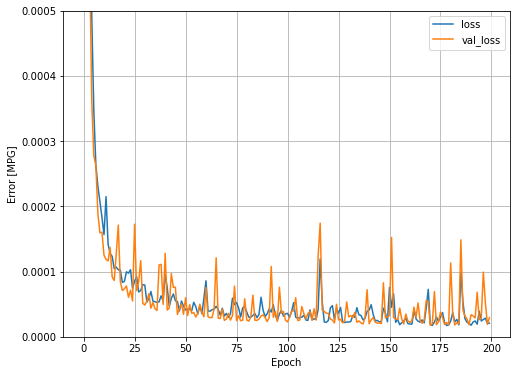

In [353]:
plot_loss(history, 0.0005)
# https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html
# '''
# It may also be identified by a validation loss that is lower than the training loss, no matter how many training iterations you perform. In this case, it indicates that the validation dataset may be easier for the model to predict than the training dataset. This can happen for various reason but is commonly associated with:

#     Information leakage where a feature in the training data has direct ties to observations and responses in the validation data (i.e. patient ID).
#     Poor sampling procedures where duplicate observations exist in the training and validation datasets.
#     Validation dataset contains features with less variance than the training dataset.
    
# Solution:

#     Check to make sure duplicate observations do not exists across training and validation datasets.
#     Check to make sure there is no information leakage across training and validation datasets.
#     Make sure that you are randomly sampling observations to use in your training and validation sets so that feature variance is consistent across both sets. ℹ️
#     Perform cross-validation so that all your data has the opportunity to be represented in both the training and validation sets. ℹ️
# https://www.baeldung.com/cs/learning-curve-ml
# '''



In [238]:
predicted_stock_price = model.predict(X_test)
# predicted_stock_price
predicted_data = inverse_prediction(predicted_stock_price)
predicted_dataset = sc.inverse_transform(pd.DataFrame(dataset_sc))
predicted_dataset[-2, 0:30], predicted_data[-2]

(array([39.57880402, 37.28424072, 38.0074234 , 37.65030289, 37.17711258,
        37.06997299, 36.82890701, 37.67708588, 38.14135361, 38.49847412,
        38.41812515, 38.65025711, 38.6591835 , 39.75735855, 39.4984436 ,
        39.07880783, 38.62347794, 38.8377533 , 38.44491577, 38.36455154,
        38.0520668 , 37.4449501 , 37.54315948, 38.2395668 , 38.27528   ,
        38.21278   , 38.7216835 , 37.73958969, 38.49847412, 39.19487762]),
 array([39.19987], dtype=float32))

In [121]:
X.shape, y.shape,X_test.shape, y_test.shape

((2000, 1, 128), (2000,), (237, 1, 128), (237,))

In [150]:
tf.keras.backend.clear_session()

In [152]:
model = Sequential([
    Dense(512, activation="relu"),
    Dropout(0.25),
    Dense(10, activation="relu"),
    Dropout(0.25),
    Dense(1)
])

In [153]:
callbacks = [
    ModelCheckpoint("stock_predictor_sequential.keras",  
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(X,y,
                    epochs=100,
                    batch_size=16,
#                     validation_data=0.15,
                    validation_split=0.1,
                    callbacks=callbacks)
model = load_model("stock_predictor_sequential.keras")      
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

# model.evaluate(x_test, y_test, batch_size=128

Epoch 1/100
113/113 [==============================] - 0s 3ms/step - loss: 0.0472 - mae: 0.1451 - val_loss: 0.0078 - val_mae: 0.0715
Epoch 2/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0217 - mae: 0.1009 - val_loss: 0.0012 - val_mae: 0.0287
Epoch 3/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0170 - mae: 0.0875 - val_loss: 0.0104 - val_mae: 0.0848
Epoch 4/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0130 - mae: 0.0741 - val_loss: 0.0049 - val_mae: 0.0483
Epoch 5/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0123 - mae: 0.0687 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 6/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0100 - mae: 0.0611 - val_loss: 7.3492e-04 - val_mae: 0.0191
Epoch 7/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0091 - mae: 0.0608 - val_loss: 0.0029 - val_mae: 0.0375
Epoch 8/100
113/113 [==============================] - 0s 2ms/ste

Epoch 61/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0050 - mae: 0.0445 - val_loss: 7.8478e-04 - val_mae: 0.0171
Epoch 62/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0470 - val_loss: 8.0120e-04 - val_mae: 0.0193
Epoch 63/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0466 - val_loss: 8.6368e-04 - val_mae: 0.0220
Epoch 64/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0460 - val_loss: 8.6133e-04 - val_mae: 0.0217
Epoch 65/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0053 - mae: 0.0453 - val_loss: 0.0015 - val_mae: 0.0291
Epoch 66/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0470 - val_loss: 8.9073e-04 - val_mae: 0.0184
Epoch 67/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0058 - mae: 0.0477 - val_loss: 0.0014 - val_mae: 0.0264
Epoch 68/100
113/113 [====================

In [154]:
scores = model.evaluate(X_test, y_test)
# preds = model.predict(X_test, batch_size=16)

8/8 [==============================] - 0s 873us/step - loss: 3.4225e-04 - mean_absolute_error: 0.0136


In [155]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 512)            66048     
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 10)             5130      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              11        
Total params: 71,189
Trainable params: 71,189
Non-trainable params: 0
_________________________________________________________________


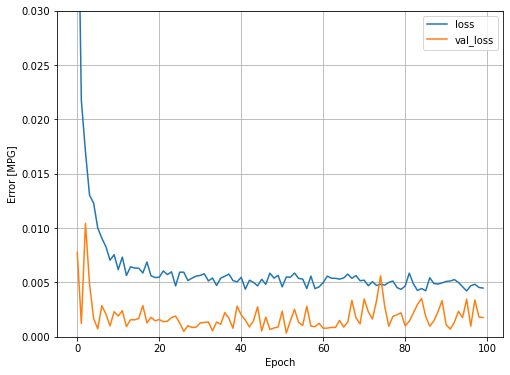

In [156]:
plot_loss(history)

In [194]:
predicted_stock_price = model.predict(X_test)
# predicted_stock_price
predicted_data = inverse_prediction(predicted_stock_price)
predicted_dataset = sc.inverse_transform(pd.DataFrame(dataset_sc))
predicted_dataset[-2, 0:30], predicted_data[-2]
# len(predicted_dataset[2000:, 0:1]), len(predicted_data)


(array([39.57880402, 37.28424072, 38.0074234 , 37.65030289, 37.17711258,
        37.06997299, 36.82890701, 37.67708588, 38.14135361, 38.49847412,
        38.41812515, 38.65025711, 38.6591835 , 39.75735855, 39.4984436 ,
        39.07880783, 38.62347794, 38.8377533 , 38.44491577, 38.36455154,
        38.0520668 , 37.4449501 , 37.54315948, 38.2395668 , 38.27528   ,
        38.21278   , 38.7216835 , 37.73958969, 38.49847412, 39.19487762]),
 array([[38.690002]], dtype=float32))

In [259]:
tf.keras.backend.clear_session()

In [260]:
inputs = Input(shape=(1, 128))
x = Flatten()(inputs)
# x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
  
callbacks = [
    ModelCheckpoint("stock_predictor_linear_regression1.keras",  
                                    save_best_only=True)
] 
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X,y,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=callbacks)
  
model = load_model("stock_predictor_linear_regression1.keras")      
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")


# "rmsprop"

Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 0.0221 - mae: 0.1196 - val_loss: 0.0124 - val_mae: 0.0912
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0102 - mae: 0.0815 - val_loss: 0.0080 - val_mae: 0.0727
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0071 - mae: 0.0661 - val_loss: 0.0060 - val_mae: 0.0614
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0052 - mae: 0.0558 - val_loss: 0.0047 - val_mae: 0.0537
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0516 - val_loss: 0.0045 - val_mae: 0.0528
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0037 - val_mae: 0.0479
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0445 - val_loss: 0.0029 - val_mae: 0.0425
Epoch 8/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0028 - m

Epoch 61/100
44/44 [==============================] - 0s 1ms/step - loss: 3.9279e-04 - mae: 0.0152 - val_loss: 4.0001e-04 - val_mae: 0.0152
Epoch 62/100
44/44 [==============================] - 0s 1ms/step - loss: 3.3329e-04 - mae: 0.0142 - val_loss: 3.4053e-04 - val_mae: 0.0139
Epoch 63/100
44/44 [==============================] - 0s 1ms/step - loss: 4.3574e-04 - mae: 0.0160 - val_loss: 3.3548e-04 - val_mae: 0.0138
Epoch 64/100
44/44 [==============================] - 0s 1ms/step - loss: 3.6616e-04 - mae: 0.0146 - val_loss: 3.4256e-04 - val_mae: 0.0139
Epoch 65/100
44/44 [==============================] - 0s 1ms/step - loss: 3.3709e-04 - mae: 0.0142 - val_loss: 3.2662e-04 - val_mae: 0.0138
Epoch 66/100
44/44 [==============================] - 0s 1ms/step - loss: 3.6241e-04 - mae: 0.0146 - val_loss: 3.4792e-04 - val_mae: 0.0141
Epoch 67/100
44/44 [==============================] - 0s 1ms/step - loss: 3.7418e-04 - mae: 0.0149 - val_loss: 3.1833e-04 - val_mae: 0.0134
Epoch 68/100
44/44 [

In [261]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [262]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
95,0.000219,0.011400,0.000229,0.011480,95
96,0.000292,0.012797,0.000408,0.015899,96
97,0.000241,0.011875,0.000223,0.011298,97
98,0.000211,0.011238,0.000241,0.011668,98
99,0.000227,0.011501,0.000331,0.013859,99


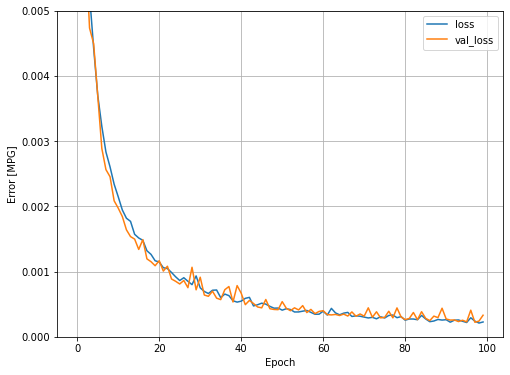

In [263]:
plot_loss(history)

In [354]:
tf.keras.backend.clear_session()

In [355]:
inputs = Input(shape=(1, 128))
x = GRU(64, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = GRU(32, recurrent_dropout=0.1, return_sequences=True)(x)
# x = Dropout(0.25)(x)
x = GRU(16, recurrent_dropout=0.1)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)


callbacks = [
    ModelCheckpoint("stock_predictor_gpu1.keras",
                                    save_best_only=True)
]
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5) 
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])
history = model.fit(X,y,
                    epochs=100,
                    validation_split=0.15,
                    callbacks=[callbacks]) #[callbacks, es]

model = load_model("stock_predictor_gpu1.keras")
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

Epoch 1/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0203 - mae: 0.0943 - val_loss: 0.0036 - val_mae: 0.0448
Epoch 2/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0311 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 7.6984e-04 - mae: 0.0208 - val_loss: 5.4612e-04 - val_mae: 0.0176
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 4.1111e-04 - mae: 0.0151 - val_loss: 2.8519e-04 - val_mae: 0.0130
Epoch 5/100
54/54 [==============================] - 0s 6ms/step - loss: 2.5084e-04 - mae: 0.0115 - val_loss: 1.6052e-04 - val_mae: 0.0093
Epoch 6/100
54/54 [==============================] - 0s 6ms/step - loss: 1.6057e-04 - mae: 0.0095 - val_loss: 1.4454e-04 - val_mae: 0.0091
Epoch 7/100
54/54 [==============================] - 0s 6ms/step - loss: 1.4518e-04 - mae: 0.0093 - val_loss: 1.3525e-04 - val_mae: 0.0088
Epoch 8/100
54/54 [=======================

Epoch 60/100
54/54 [==============================] - 0s 5ms/step - loss: 3.8887e-05 - mae: 0.0047 - val_loss: 2.3850e-05 - val_mae: 0.0038
Epoch 61/100
54/54 [==============================] - 0s 4ms/step - loss: 4.0209e-05 - mae: 0.0048 - val_loss: 1.0239e-04 - val_mae: 0.0085
Epoch 62/100
54/54 [==============================] - 0s 5ms/step - loss: 6.2916e-05 - mae: 0.0057 - val_loss: 2.4937e-05 - val_mae: 0.0038
Epoch 63/100
54/54 [==============================] - 0s 4ms/step - loss: 3.7783e-05 - mae: 0.0046 - val_loss: 5.8893e-05 - val_mae: 0.0063
Epoch 64/100
54/54 [==============================] - 0s 4ms/step - loss: 3.4262e-05 - mae: 0.0044 - val_loss: 3.2925e-05 - val_mae: 0.0045
Epoch 65/100
54/54 [==============================] - 0s 4ms/step - loss: 5.5601e-05 - mae: 0.0057 - val_loss: 1.7990e-04 - val_mae: 0.0105
Epoch 66/100
54/54 [==============================] - 0s 4ms/step - loss: 4.0627e-05 - mae: 0.0049 - val_loss: 2.6420e-05 - val_mae: 0.0040
Epoch 67/100
54/54 [

In [356]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
gru (GRU)                    (None, 1, 64)             37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 32)             9408      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 49,073
Trainable params: 49,073
Non-trainable params: 0
_________________________________________________________________


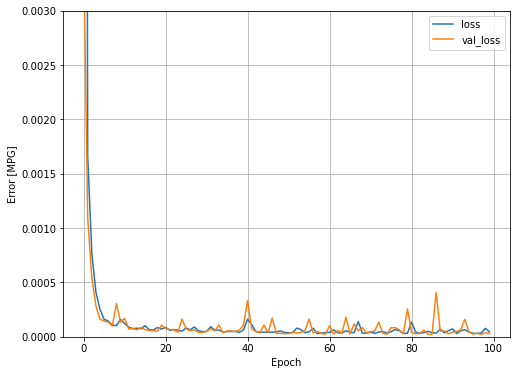

In [361]:
plot_loss(history, 0.003)

In [336]:
tf.keras.backend.clear_session()

In [337]:
inputs = Input(shape=(1, 128))
x = Bidirectional(LSTM(128))(inputs)
outputs = Dense(1)(x)
model = Model(inputs, outputs) 

callbacks = [
    ModelCheckpoint("stock_predictor_bidirectional1.keras",
                                    save_best_only=True)
    ]
    
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X,y,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[callbacks]) #[callbacks, es]

model = load_model("stock_predictor_bidirectional1.keras")
print(f"Test MAE: {model.evaluate(X_test, y_test)[1]:.2f}")

Epoch 1/50
50/50 [==============================] - 1s 21ms/step - loss: 0.0097 - mae: 0.0625 - val_loss: 0.0013 - val_mae: 0.0279
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 5.6610e-04 - mae: 0.0175 - val_loss: 2.9897e-04 - val_mae: 0.0130
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 2.6462e-04 - mae: 0.0121 - val_loss: 1.4915e-04 - val_mae: 0.0093
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 1.4498e-04 - mae: 0.0087 - val_loss: 9.8421e-05 - val_mae: 0.0078
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 1.1695e-04 - mae: 0.0080 - val_loss: 1.0473e-04 - val_mae: 0.0078
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 9.9990e-05 - mae: 0.0075 - val_loss: 7.0658e-05 - val_mae: 0.0066
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 8.7994e-05 - mae: 0.0071 - val_loss: 5.9156e-05 - val_mae: 0.0060
Epoch 8/50
50/50 [=======================

Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000020706D695E0>
Traceback (most recent call last):
  File "C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'deleter'


8/8 [==============================] - 0s 2ms/step - loss: 3.8232e-05 - mean_absolute_error: 0.0046
Test MAE: 0.00


In [339]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 128)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 263,425
Trainable params: 263,425
Non-trainable params: 0
_________________________________________________________________


In [340]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mae,val_loss,val_mae,epoch
40,0.000050,0.005258,0.000043,0.004812,40
41,0.000038,0.004573,0.000042,0.005164,41
42,0.000041,0.004854,0.000053,0.005739,42
43,0.000075,0.006492,0.000257,0.013642,43
44,0.000055,0.005635,0.000163,0.009231,44
45,0.000052,0.005566,0.000081,0.006683,45
46,0.000106,0.008203,0.000035,0.004558,46
47,0.000050,0.005171,0.000035,0.004538,47
48,0.000034,0.004400,0.000028,0.003972,48
49,0.000036,0.004441,0.000029,0.004132,49


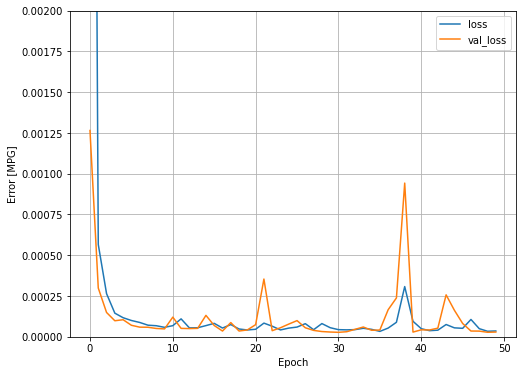

In [346]:
# plot_loss(history, hist['val_loss'].mean()*10)
plot_loss(history, 0.002)